In [9]:
!pip install sentence-transformers scikit-learn matplotlib seaborn nltk rouge-score sacrebleu

In [197]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from rouge_score import rouge_scorer
import sacrebleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [199]:
df = pd.read_csv(r'd:\s\ai-project\data\labeled_resume_job_dataset.csv')
print(df.head())
print(df['Match_Label'].value_counts())

                                         Resume_Text  \
0  Skills: Patient Care, Medical Terminology, EHR...   
1  Skills: Curriculum Development, Classroom Mana...   
2  Skills: Financial Analysis, Risk Assessment, G...   
3  Skills: Pharmacology, Clinical Research, FDA R...   
4  Skills: AutoCAD, Structural Design, Building C...   

                                     Job_Description  Match_Label  
0  Seeking RN with 3+ years experience in acute c...            1  
1  Mathematics teacher needed with experience in ...            1  
2  Corporate finance manager required with CFA ce...            1  
3  Marketing manager needed for OTC healthcare pr...            0  
4  Architectural designer position requiring BIM ...            0  
Match_Label
1    801
0    412
Name: count, dtype: int64


In [201]:
X = df[['Resume_Text', 'Job_Description']]
y = df['Match_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 970, Test size: 243


In [223]:
# Load a pre-trained SBERT model
model = SentenceTransformer('all-mpnet-base-v2')

def compute_similarity(resumes, jobs):
    resume_emb = model.encode(resumes, convert_to_tensor=True)
    job_emb = model.encode(jobs, convert_to_tensor=True)
    # Cosine similarity
    sim = (resume_emb * job_emb).sum(dim=1) / (resume_emb.norm(dim=1) * job_emb.norm(dim=1))
    return sim.cpu().numpy()

# Compute similarities for train and test
train_sim = compute_similarity(X_train['Resume_Text'].tolist(), X_train['Job_Description'].tolist())
test_sim = compute_similarity(X_test['Resume_Text'].tolist(), X_test['Job_Description'].tolist())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [225]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, train_sim)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.598


In [227]:
y_pred = (test_sim >= optimal_threshold).astype(int)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, test_sim)
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.856, F1: 0.881, ROC-AUC: 0.877
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        83
           1       0.97      0.81      0.88       160

    accuracy                           0.86       243
   macro avg       0.84      0.88      0.85       243
weighted avg       0.88      0.86      0.86       243



In [229]:
# Extract features for train and test sets
train_features = np.array([extract_features(resume, job) for resume, job in zip(X_train['Resume_Text'], X_train['Job_Description'])])
test_features = np.array([extract_features(resume, job) for resume, job in zip(X_test['Resume_Text'], X_test['Job_Description'])])

In [230]:
# Combine similarity and contextual features
train_X = np.hstack([train_sim.reshape(-1, 1), train_features])
test_X = np.hstack([test_sim.reshape(-1, 1), test_features])

# Train a logistic regression classifier
clf = LogisticRegression(class_weight='balanced', random_state=42)  # Balanced weights for better recall
clf.fit(train_X, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [231]:
# Predict and evaluate
y_pred = clf.predict(test_X)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(test_X)[:, 1])
print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.835, F1: 0.864, ROC-AUC: 0.885
              precision    recall  f1-score   support

           0       0.70      0.92      0.79        83
           1       0.95      0.79      0.86       160

    accuracy                           0.84       243
   macro avg       0.82      0.85      0.83       243
weighted avg       0.86      0.84      0.84       243



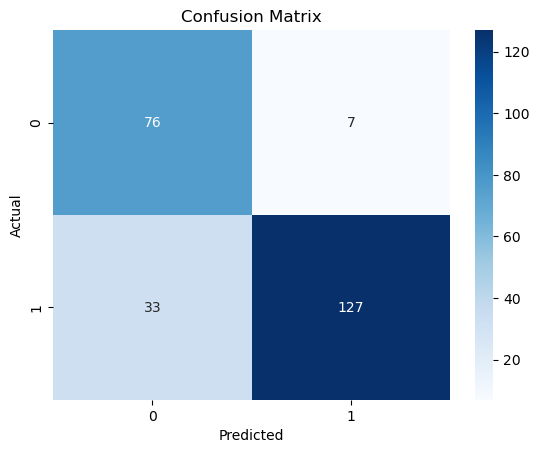

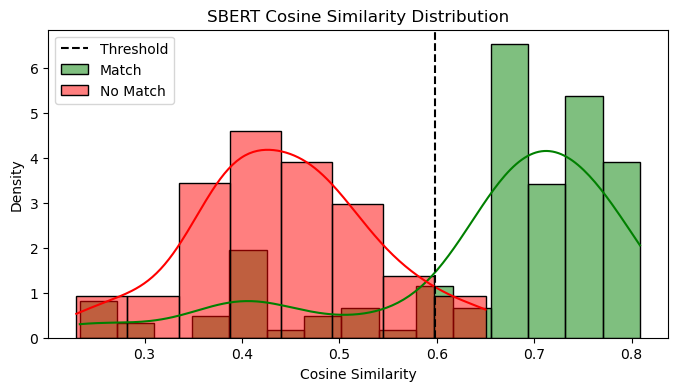

In [232]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Distribution of Similarity Scores
plt.figure(figsize=(8,4))
sns.histplot(test_sim[y_test==1], color='g', label='Match', kde=True, stat='density')
sns.histplot(test_sim[y_test==0], color='r', label='No Match', kde=True, stat='density')
plt.axvline(optimal_threshold, color='k', linestyle='--', label='Threshold')
plt.legend()
plt.title('SBERT Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.show()

In [233]:
# BLEU (using sacrebleu)
bleu = sacrebleu.corpus_bleu(X_test['Resume_Text'].tolist(), [X_test['Job_Description'].tolist()])
print(f"Corpus BLEU: {bleu.score:.2f}")

# ROUGE (using rouge-score)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1, rouge2, rougel = [], [], []
for ref, hyp in zip(X_test['Job_Description'], X_test['Resume_Text']):
    scores = scorer.score(ref, hyp)
    rouge1.append(scores['rouge1'].fmeasure)
    rouge2.append(scores['rouge2'].fmeasure)
    rougel.append(scores['rougeL'].fmeasure)
print(f"ROUGE-1: {np.mean(rouge1):.3f}, ROUGE-2: {np.mean(rouge2):.3f}, ROUGE-L: {np.mean(rougel):.3f}")

Corpus BLEU: 0.83
ROUGE-1: 0.246, ROUGE-2: 0.068, ROUGE-L: 0.168


In [243]:
for i in range(6):
    print(f"Resume: {X_test.iloc[i]['Resume_Text']}")
    print(f"Job: {X_test.iloc[i]['Job_Description']}")
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}, Similarity: {test_sim[i]:.3f}\n")

Resume: Skills: Data Entry, Microsoft Excel, CRM Systems. Experience: Administrative Assistant at OfficePlus. Projects: Customer Database Cleanup, Monthly Reporting Automation.
Job: Sales representative needed for outbound campaigns and CRM management.
Actual: 0, Predicted: 0, Similarity: 0.532

Resume: Skills: Data Entry, Microsoft Excel, CRM Systems. Experience: Administrative Assistant at OfficePlus. Projects: Customer Database Cleanup, Monthly Reporting Automation.
Job: Looking for digital marketer with PPC and social media advertising experience.
Actual: 0, Predicted: 0, Similarity: 0.457

Resume: Skills: Full Stack Development, React, Node.js, PostgreSQL. Experience: Full Stack Developer at CodeCrafters. Projects: E-commerce Platform, Real-time Chat App.
Job: Sales representative needed for outbound campaigns and CRM management.
Actual: 0, Predicted: 0, Similarity: 0.387

Resume: Skills: Java, Spring Boot, RESTful APIs. Experience: Java Developer at CodeCraft. Projects: E-commerc